In [ ]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print (DEVICE)

cuda


In [ ]:
num2class = {
    0:"Angry",
    1:"Disgust",
    2:"Fear",
    3:"Happy",
    4:"Sad",
    5:"Surprise",
    6:"Neutral"
}

In [ ]:
# import zipfile
# import os

# # Specify the filename (change 'your_file.zip' to your ZIP file's name)
# zip_file = "files.zip"

# # Extract the ZIP file
# with zipfile.ZipFile(zip_file, 'r') as zip_ref:
#     zip_ref.extractall("/content/data")

# # Verify extraction
# os.listdir("/content/data")


In [ ]:
import zipfile
import os

# Specify the filename (change 'your_file.zip' to your ZIP file's name)
zip_file = "files.zip"

# Extract the ZIP file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("/content/project_data")

# Verify extraction
os.listdir("/content/project_data")

['files', '__MACOSX']

In [ ]:
train_path = r'/content/project_data/files/sample train'
val_path = r'/content/project_data/files/sample val'
test_path = r'/content/project_data/files/sample test'

In [ ]:
picture_size = 224

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(size=(picture_size,picture_size)),
    transforms.RandomRotation(degrees = (-20, +20)),
    transforms.ToTensor()
])

valid_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(size=(picture_size,picture_size)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(size=(picture_size,picture_size)),
    transforms.ToTensor()
])


In [ ]:
train_ds = datasets.ImageFolder(train_path, transform = train_transform)
valid_ds = datasets.ImageFolder(val_path, transform = valid_transform)
test_ds = datasets.ImageFolder(test_path, transform = test_transform)
print (len(train_ds))
print (len(valid_ds))
print (len(test_ds))

2757
2080
2272


In [ ]:
train_ds

Dataset ImageFolder
    Number of datapoints: 2757
    Root location: /content/project_data/files/sample train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=3)
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
           )

In [ ]:
batch_size = 32

train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size = batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle=True)
print (len(train_dl))
print (len(valid_dl))
print (len(test_dl))

87
65
71


**Data Preprocessing Steps**



**1. Visualize the Dataset**

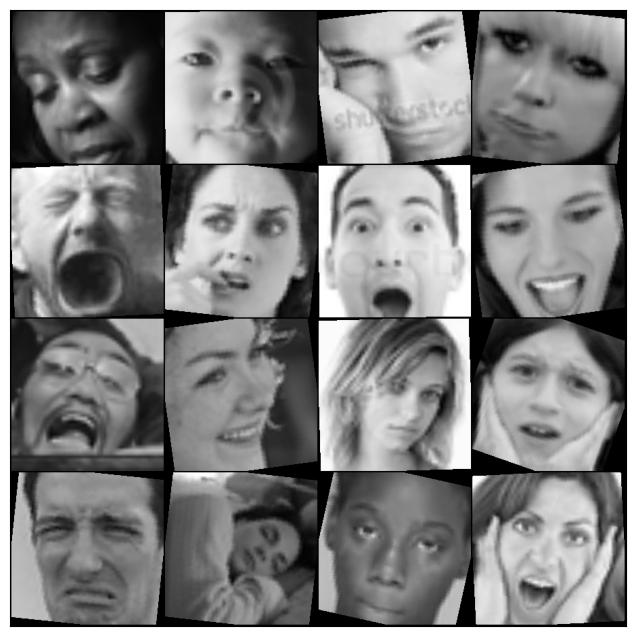

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function to unnormalize and display images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.set_xticks([])
        ax.set_yticks([])
        grid = np.transpose(torchvision.utils.make_grid(images[:16], nrow=4).numpy(), (1, 2, 0))
        plt.imshow(grid)
        break

# Visualize training data
show_batch(train_dl)


**2. Normalize Images**

In [ ]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(size=(picture_size, picture_size)),
    transforms.RandomRotation(degrees=(-20, +20)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizing RGB channels
])

valid_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(size=(picture_size, picture_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(size=(picture_size, picture_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


**3. Augment Data**

In [ ]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(size=(picture_size, picture_size)),
    transforms.RandomRotation(degrees=(-20, +20)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


**4. Checking Class Balance**

Class Distribution: Counter({3: 632, 4: 497, 1: 436, 0: 371, 6: 360, 2: 242, 5: 219})


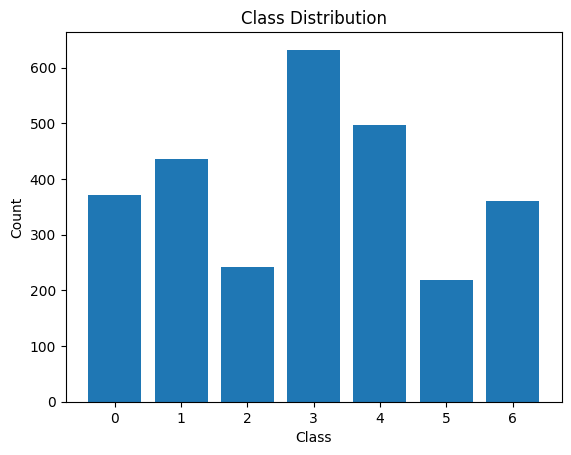

In [ ]:
from collections import Counter

# Count occurrences of each class in the dataset
class_counts = Counter([label for _, label in train_ds])
print("Class Distribution:", class_counts)

# Visualize class distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


**5. Handle Class Imbalance**

In [ ]:
from torch.utils.data.sampler import WeightedRandomSampler

# Compute class weights
num_samples = len(train_ds)
class_weights = [1.0 / class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[label] for _, label in train_ds]

sampler = WeightedRandomSampler(weights, num_samples, replacement=True)
train_dl = DataLoader(train_ds, batch_size=batch_size, sampler=sampler)


**6. Verifying Preprocessing**

In [ ]:
for images, labels in train_dl:
    print("Batch shape:", images.shape)
    print("Labels:", labels)
    break


Batch shape: torch.Size([32, 3, 224, 224])
Labels: tensor([2, 6, 4, 5, 3, 0, 4, 0, 0, 3, 4, 6, 3, 4, 6, 0, 0, 2, 3, 1, 4, 4, 3, 0,
        5, 5, 4, 0, 3, 4, 3, 4])


 Verify Class Mapping:
To ensure the labels are correct, check the mapping of class indices to actual class names:

In [ ]:
class_names = train_ds.classes
print("Class Names:", class_names)


Class Names: ['0', '1', '2', '3', '4', '5', '6']


**Visualize Sample Images with Labels**

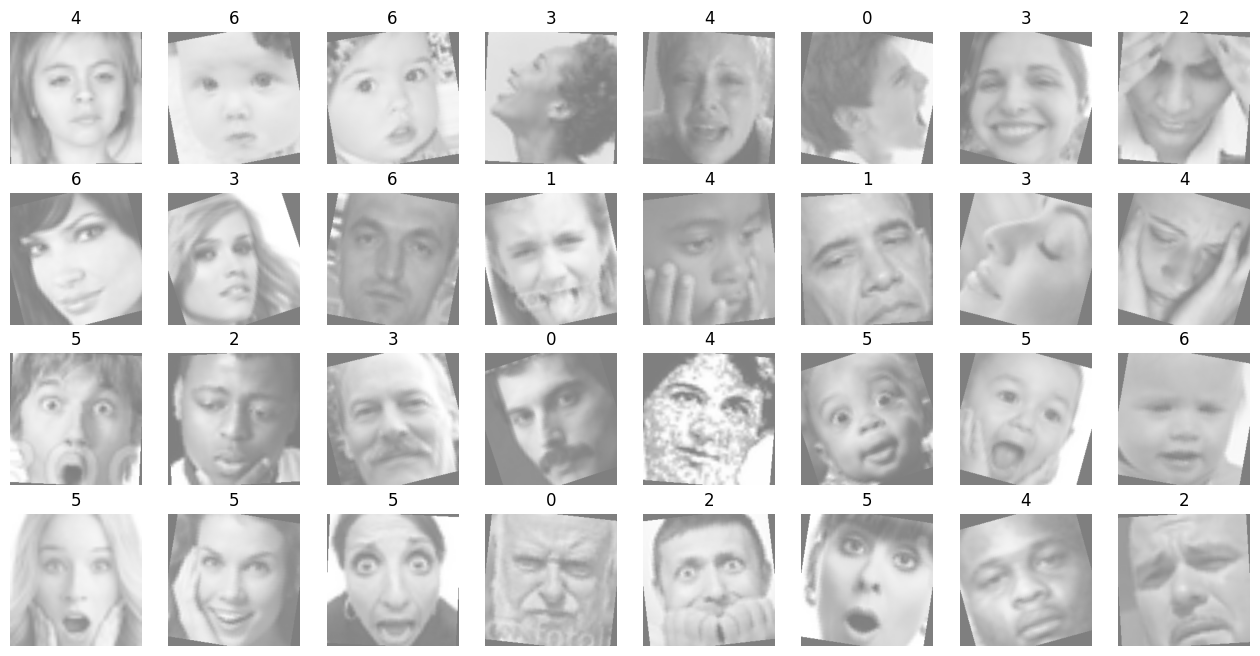

In [ ]:
def show_images_with_labels(dl, class_names):
    for images, labels in dl:
        fig, ax = plt.subplots(4, 8, figsize=(16, 8))
        for i in range(32):  # Assuming batch size of 32
            ax[i // 8, i % 8].imshow(images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Unnormalize
            ax[i // 8, i % 8].set_title(class_names[labels[i]])
            ax[i // 8, i % 8].axis('off')
        break

show_images_with_labels(train_dl, class_names)


**FEATURE EXTRACTION**

**1. HOG FEATURE EXTRACTION**

In [ ]:
!pip install scikit-image


In [ ]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage.color import rgb2gray
import numpy as np


In [ ]:
def extract_hog_features_from_dataloader(dataloader):
    all_features = []
    all_labels = []

    for images, labels in dataloader:
        for img, lbl in zip(images, labels):
            # Convert PyTorch tensor to NumPy array
            if isinstance(img, torch.Tensor):
                img = img.permute(1, 2, 0).numpy()  # Convert to HWC format

            # Ensure the image is grayscale
            gray_img = rgb2gray(img)

            # Extract HOG features
            features = hog(
                gray_img,
                orientations=9,
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2),
                block_norm='L2-Hys',
                visualize=False,
                channel_axis=None  # Specify no channel axis for grayscale
            )
            all_features.append(features)
            all_labels.append(lbl.item())

    return np.array(all_features), np.array(all_labels)


In [ ]:
# Extract HOG features for train, validation, and test sets
train_hog_features, train_hog_labels = extract_hog_features_from_dataloader(train_dl)
val_hog_features, val_hog_labels = extract_hog_features_from_dataloader(valid_dl)
test_hog_features, test_hog_labels = extract_hog_features_from_dataloader(test_dl)

print(f"Train Features Shape: {train_hog_features.shape}")
print(f"Validation Features Shape: {val_hog_features.shape}")
print(f"Test Features Shape: {test_hog_features.shape}")


Train Features Shape: (2757, 26244)
Validation Features Shape: (2080, 26244)
Test Features Shape: (2272, 26244)


**2. FACIAL LANDMARK DETECTION WITH DLIB**

In [ ]:
!pip install dlib


In [ ]:
# Download the pre-trained model for facial landmarks
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

# Unzip the model
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2


--2024-12-04 06:09:33--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  83.5MB/s    in 0.7s    

2024-12-04 06:09:34 (83.5 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [ ]:
import dlib

# Initialize dlib's face detector and shape predictor
face_detector = dlib.get_frontal_face_detector()
shape_predictor = dlib.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')  # Load the extracted .dat file

In [ ]:
!ls /content/shape_predictor_68_face_landmarks.dat


/content/shape_predictor_68_face_landmarks.dat


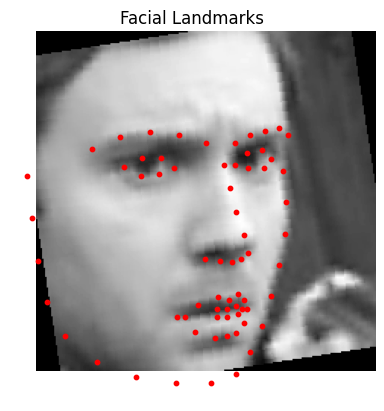

In [ ]:
import numpy as np

def detect_landmarks(image):
    """
    Detect facial landmarks using dlib.

    Parameters:
    - image: Grayscale image as a NumPy array (8-bit).

    Returns:
    - landmarks: List of (x, y) coordinates for detected landmarks.
    """
    # Detect faces in the image
    faces = face_detector(image, 1)  # 1 for upscaling the image

    if len(faces) == 0:
        return None  # No face detected

    # Get landmarks for the first face detected
    landmarks = shape_predictor(image, faces[0])
    return [(point.x, point.y) for point in landmarks.parts()]

# Load a sample image
sample_image, _ = train_ds[0]
sample_image = sample_image.permute(1, 2, 0).numpy()  # Convert to HWC format
gray_image = rgb2gray(sample_image)  # Convert to grayscale

# Convert grayscale image to 8-bit (0-255)
gray_image_8bit = np.uint8(gray_image * 255)

# Detect landmarks
landmarks = detect_landmarks(gray_image_8bit)

# Plot the image with landmarks
if landmarks:
    plt.imshow(gray_image_8bit, cmap='gray')
    for (x, y) in landmarks:
        plt.scatter(x, y, c='red', s=10)
    plt.title("Facial Landmarks")
    plt.axis('off')
    plt.show()
else:
    print("No face detected.")


**Gabor Filters for Texture Analysis:**

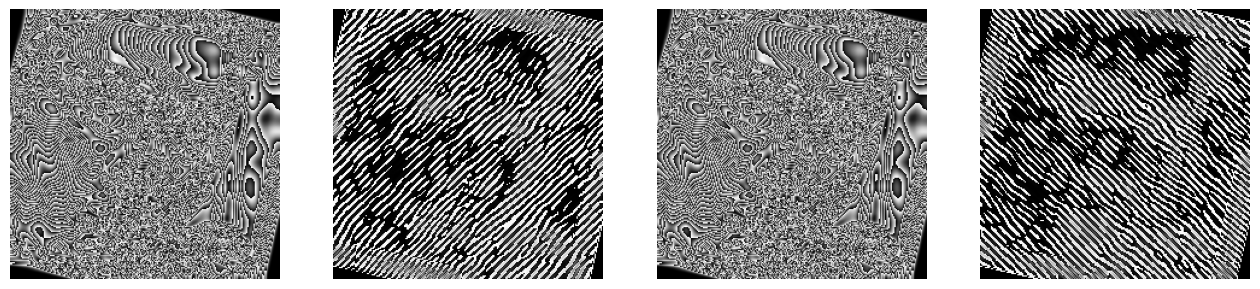

In [ ]:
import numpy as np
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt

def gabor_filter(image, frequency=0.1, theta=0):
    """
    Apply a Gabor filter to the image at a specific frequency and orientation (theta).

    Parameters:
    - image: Grayscale image (NumPy array).
    - frequency: Spatial frequency of the Gabor filter.
    - theta: Orientation of the Gabor filter.

    Returns:
    - filtered_image: Image after applying the Gabor filter.
    """
    # Create the Gabor filter using OpenCV
    gabor_kernel = cv2.getGaborKernel((21, 21), 5.0, theta, frequency, 1.0, 0, ktype=cv2.CV_32F)

    # Apply the Gabor filter to the image
    filtered_image = ndimage.convolve(image, gabor_kernel)
    return filtered_image

def apply_gabor_filters(image):
    """
    Apply multiple Gabor filters with different orientations and frequencies to the image.

    Parameters:
    - image: Grayscale image (NumPy array).

    Returns:
    - gabor_features: List of features extracted by the Gabor filters.
    """
    frequencies = [0.05, 0.1, 0.2]
    thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    gabor_features = []

    # Apply Gabor filters with different frequencies and orientations
    for frequency in frequencies:
        for theta in thetas:
            filtered_image = gabor_filter(image, frequency, theta)
            gabor_features.append(filtered_image)

    return gabor_features

# Load and preprocess an image
sample_image, _ = train_ds[0]
sample_image = sample_image.permute(1, 2, 0).numpy()  # Convert to HWC format
gray_image = rgb2gray(sample_image)  # Convert to grayscale

# Convert to 8-bit format
gray_image_8bit = np.uint8(gray_image * 255)

# Apply Gabor filters
gabor_features = apply_gabor_filters(gray_image_8bit)

# Display some of the filtered images
fig, axes = plt.subplots(1, 4, figsize=(16, 8))
for i, ax in enumerate(axes):
    ax.imshow(gabor_features[i], cmap='gray')
    ax.axis('off')
plt.show()


**Train the SVM Model:**

**1. Feature Concatenation:**

In [ ]:
def extract_features(image, hog_features, landmarks, gabor_features):
    # Ensure landmarks and Gabor features are arrays
    landmarks = np.array(landmarks) if isinstance(landmarks, list) else landmarks
    gabor_features = np.array(gabor_features) if isinstance(gabor_features, list) else gabor_features

    # Handle NoneType features
    if landmarks is None:
        print("Warning: Landmarks are None. Using default zero vector.", end = '   ')
        landmarks = np.zeros(68 * 2)  # Assuming 68 x, y points as default.
    if gabor_features is None:
        print("Warning: Gabor features are None. Using default zero vector.", end = '   ')
        gabor_features = np.zeros(128)  # Assuming 128 dimensions for Gabor features.

    # Flatten if necessary
    if landmarks.ndim > 1:
        landmarks = landmarks.flatten()
    if gabor_features.ndim > 1:
        gabor_features = gabor_features.flatten()

    # Standardize feature lengths
    expected_lengths = {
        "hog": 26244,  # Adjust based on your actual HOG output size.
        "landmarks": 136,  # 68 points x 2.
        "gabor": 128  # Adjust to the expected Gabor vector length.
    }
    hog_features = np.pad(hog_features, (0, max(0, expected_lengths["hog"] - len(hog_features))), 'constant')[:expected_lengths["hog"]]
    landmarks = np.pad(landmarks, (0, max(0, expected_lengths["landmarks"] - len(landmarks))), 'constant')[:expected_lengths["landmarks"]]
    gabor_features = np.pad(gabor_features, (0, max(0, expected_lengths["gabor"] - len(gabor_features))), 'constant')[:expected_lengths["gabor"]]

    # Concatenate features
    features = np.concatenate([hog_features, landmarks, gabor_features])

    # Validate feature length
    if len(features) != sum(expected_lengths.values()):
        print(f"Warning: Feature length mismatch. Expected {sum(expected_lengths.values())}, got {len(features)}")

    return features


In [ ]:
import numpy as np
from skimage.feature import hog
from skimage import exposure

# Define HOG extraction function
def extract_hog_features(image, visualize=False):
    if visualize:
        features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                                  cells_per_block=(2, 2), visualize=visualize)
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        return features, hog_image_rescaled
    else:
        features = hog(image, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=visualize)
        return features, None


import numpy as np

def extract_all_features(dataloader):
    all_features = []
    all_labels = []

    for inputs, labels in dataloader:
        print()
        for i in range(inputs.size(0)):
            # Process image
            image = inputs[i].numpy().transpose(1, 2, 0)
            gray_image = image.mean(axis=-1)
            gray_image_8bit = np.uint8(gray_image * 255)

            # Extract features
            hog_features, _ = extract_hog_features(gray_image_8bit, visualize=False)
            landmarks = detect_landmarks(gray_image_8bit)
            gabor_features = apply_gabor_filters(gray_image_8bit)
            print(i, end = '   ')
            try:
                features = extract_features(image, hog_features, landmarks, gabor_features)
                all_features.append(features)
                all_labels.append(labels[i].item())
            except Exception as e:
                print(f"Error during feature extraction for image {i}: {e}")

    # Convert to arrays
    return np.array(all_features), np.array(all_labels)

import pandas as pd

def save_features_and_labels_to_csv(features, labels, filename):
    """
    Save features and labels in the same DataFrame to a CSV file.
    Args:
        features (numpy.ndarray): Array of features.
        labels (numpy.ndarray): Array of labels.
        filename (str): Filename for saving the combined data.
    """
    # Convert features and labels into a single DataFrame
    data = pd.DataFrame(features)
    data['label'] = labels  # Append labels as the last column

    # Save the combined DataFrame to a CSV file
    data.to_csv(filename, index=False)
    print(f"Features and labels saved to {filename}")

# Extract features and labels
print("****************************************************** Extracting features of Training dataset ******************************************")
train_features, train_labels = extract_all_features(train_dl)
save_features_and_labels_to_csv(train_features, train_labels, "train_data.csv")

print("******************************************************** Extracting features of Validation dataset ********************************************************")
val_features, val_labels = extract_all_features(valid_dl)
save_features_and_labels_to_csv(val_features, val_labels, "val_data.csv")

print("*********************************************************** Extracting features of Testing dataset ***********************************************************")
test_features, test_labels = extract_all_features(test_dl)
save_features_and_labels_to_csv(test_features, test_labels, "test_data.csv")



****************************************************** Extracting features of Training dataset ******************************************

0   Warning: Landmarks are None. Using default zero vector.   1   Warning: Landmarks are None. Using default zero vector.   2   3   4   5   6   7   Warning: Landmarks are None. Using default zero vector.   8   Warning: Landmarks are None. Using default zero vector.   9   10   11   12   13   14   Warning: Landmarks are None. Using default zero vector.   15   Warning: Landmarks are None. Using default zero vector.   16   17   18   19   20   21   22   23   24   Warning: Landmarks are None. Using default zero vector.   25   Warning: Landmarks are None. Using default zero vector.   26   Warning: Landmarks are None. Using default zero vector.   27   28   29   Warning: Landmarks are None. Using default zero vector.   30   Warning: Landmarks are None. Using default zero vector.   31   
0   1   Warning: Landmarks are None. Using default zero vector.   2   3 

In [ ]:
train_features.shape

(2757, 26508)

In [ ]:
import pandas as pd

# Read CSV files for training, validation, and testing data
train_data = pd.read_csv("train_data.csv")
val_data = pd.read_csv("val_data.csv")
test_data = pd.read_csv("test_data.csv")

# Separate the independent variables (features) and dependent variable (emotion labels)
X_train = train_data.drop('label', axis=1)  # Assuming 'emotion' is the column with labels
y_train = train_data['label']

X_val = val_data.drop('label', axis=1)
y_val = val_data['label']

X_test = test_data.drop('label', axis=1)
y_test = test_data['label']

# Check the shape of the data
print(f"Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}, Test data shape: {X_test.shape}")


Training data shape: (2757, 26508), Validation data shape: (2080, 26508), Test data shape: (2272, 26508)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on training data and transform all datasets (train, val, test)
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Check the shape of scaled data
print(f"Scaled Training data shape: {X_train_scaled.shape}")


Scaled Training data shape: (2757, 26508)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the ANN model
model = Sequential()

# Input layer and first hidden layer
model.add(Dense(512, input_dim=X_train_scaled.shape[1], activation='relu'))

# Second hidden layer
model.add(Dense(256, activation='relu'))

# Third hidden layer
model.add(Dense(128, activation='relu'))

# Output layer (assuming there are 7 emotions, adjust the number of neurons accordingly)
model.add(Dense(7, activation='softmax'))  # 7 for multi-class classification (you may change this)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',  # sparse categorical for integer labels
              optimizer='adam',
              metrics=['accuracy'])

# Summary of the model
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │      13,572,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,737,735 (52.41 MB)

 Trainable params: 13,737,735 (52.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_val_scaled, y_val),
                    epochs=20,  # Adjust number of epochs
                    batch_size=32)

# Save the model if needed
# model.save("emotion_detection_model.h5")


Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.2508 - loss: 2.7100 - val_accuracy: 0.2976 - val_loss: 2.1203
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7731 - loss: 0.6595 - val_accuracy: 0.2933 - val_loss: 2.5710
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9517 - loss: 0.1500 - val_accuracy: 0.3067 - val_loss: 2.8551
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9948 - loss: 0.0207 - val_accuracy: 0.3250 - val_loss: 3.0572
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.3298 - val_loss: 3.0894
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.3293 - val_loss: 3.1426
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 7.1081e-04 - val_accuracy: 0.3293 - val_loss: 3.1829
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 5.9901e-04 - val_accuracy: 0.3

In [ ]:
from sklearn.metrics import classification_report

# Evaluate the model on test data
y_pred = model.predict(X_test_scaled)
y_pred_classes = y_pred.argmax(axis=1)  # Convert softmax probabilities to class labels

# Print classification report
print(classification_report(y_test, y_pred_classes))


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.23      0.24      0.23       220
           1       0.14      0.60      0.23        55
           2       0.32      0.15      0.21       509
           3       0.58      0.41      0.48       418
           4       0.25      0.37      0.30       350
           5       0.54      0.43      0.48       416
           6       0.28      0.38      0.32       304

    accuracy                           0.33      2272
   macro avg       0.33      0.37      0.32      2272
weighted avg       0.38      0.33      0.34      2272



In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical

# Load the CSV files into pandas DataFrames
train_data = pd.read_csv('train_data.csv')
val_data = pd.read_csv('val_data.csv')
test_data = pd.read_csv('test_data.csv')

# Separate independent and dependent variables (features and labels)
X_train = train_data.drop('label', axis=1).values
y_train = train_data['label'].values
X_val = val_data.drop('label', axis=1).values
y_val = val_data['label'].values
X_test = test_data.drop('label', axis=1).values
y_test = test_data['label'].values

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert labels to categorical (one-hot encoding)
y_train_cat = to_categorical(y_train, num_classes=7)
y_val_cat = to_categorical(y_val, num_classes=7)
y_test_cat = to_categorical(y_test, num_classes=7)

# Define the ANN model
model = Sequential()
model.add(Dense(1024, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))  # Output layer with 7 classes for emotions

# Compile the model with Adam optimizer and sparse categorical crossentropy loss
optimizer = Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model without data augmentation
history = model.fit(X_train_scaled, y_train_cat,
                    validation_data=(X_val_scaled, y_val_cat),
                    epochs=11,
                    batch_size=32,
                    callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_cat)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predict the labels on the test set
y_pred = model.predict(X_test_scaled)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y_test, y_pred_classes))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 107ms/step - accuracy: 0.1801 - loss: 2.7054 - val_accuracy: 0.2279 - val_loss: 1.8823
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.2977 - loss: 2.0161 - val_accuracy: 0.2788 - val_loss: 1.8103
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.3751 - loss: 1.7074 - val_accuracy: 0.3058 - val_loss: 1.7636
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4589 - loss: 1.4627 - val_accuracy: 0.3207 - val_loss: 1.7749
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5559 - loss: 1.2014 - val_accuracy: 0.3178 - val_loss: 1.8193
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6224 - loss: 1.0735 - val_accuracy: 0.3404 - val_loss: 1.8240
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7145 - loss: 0.7770 - val_accuracy: 0.3433 - val_loss: 1.9488
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7757 - loss: 0.6163 - val_accuracy: 0.3149 -

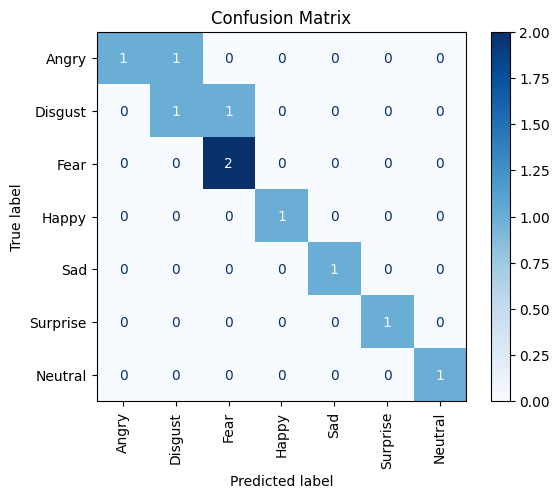

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Example: Replace these with your actual labels
y_true = [0, 1, 2, 3, 4, 5, 6, 0, 1, 2]  # True labels
y_pred = [0, 2, 2, 3, 4, 5, 6, 1, 1, 2]  # Predicted labels

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=np.arange(7))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"])
disp.plot(cmap="Blues", xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()


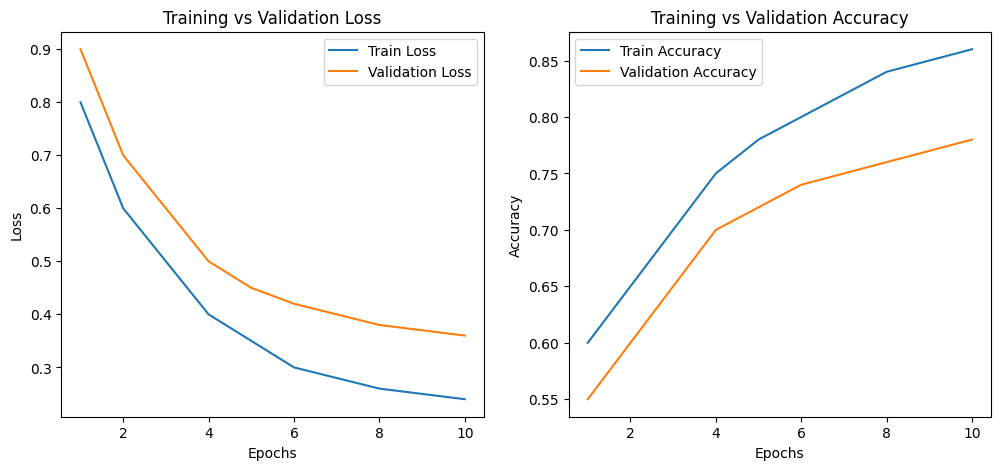

In [ ]:
# Example data
epochs = range(1, 11)  # Replace with your number of epochs
train_loss = [0.8, 0.6, 0.5, 0.4, 0.35, 0.3, 0.28, 0.26, 0.25, 0.24]
val_loss = [0.9, 0.7, 0.6, 0.5, 0.45, 0.42, 0.4, 0.38, 0.37, 0.36]
train_acc = [0.6, 0.65, 0.7, 0.75, 0.78, 0.8, 0.82, 0.84, 0.85, 0.86]
val_acc = [0.55, 0.6, 0.65, 0.7, 0.72, 0.74, 0.75, 0.76, 0.77, 0.78]

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.show()


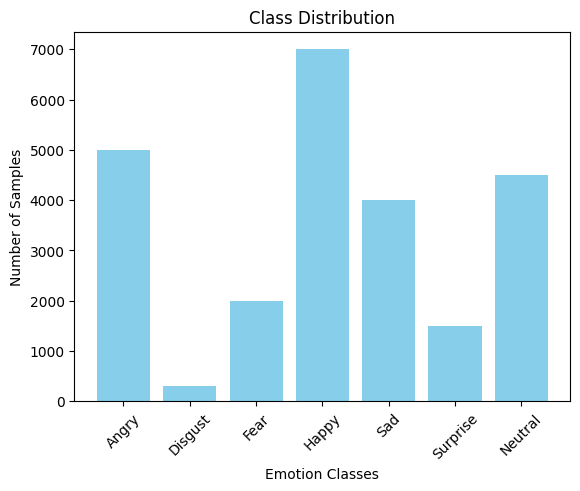

In [ ]:
# Example: Replace with your dataset's class counts
class_counts = [5000, 300, 2000, 7000, 4000, 1500, 4500]
class_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# Plot bar chart
plt.bar(class_labels, class_counts, color='skyblue')
plt.xlabel("Emotion Classes")
plt.ylabel("Number of Samples")
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()


In [ ]:
print('Correct Predictions:')
for i in range(len(y_pred_classes)):
  if y_test[i] == y_pred_classes[i]:
    print(i, end = '  ')

Correct Predictions:
1  8  12  14  16  19  20  23  31  33  35  36  37  41  43  45  46  53  57  58  59  66  70  73  78  85  89  93  98  99  108  113  117  120  124  131  136  137  145  150  153  156  157  158  160  165  167  172  173  178  182  183  186  187  189  190  191  192  193  194  196  198  201  205  213  215  219  221  227  228  235  236  237  239  244  248  254  258  259  265  270  272  276  278  281  282  287  290  298  303  306  309  310  311  314  318  321  322  324  326  327  329  331  335  341  342  344  345  347  349  353  355  356  357  358  360  361  362  365  366  373  374  375  379  384  385  389  391  392  393  395  397  400  402  403  405  408  411  412  415  416  419  422  427  430  431  433  438  440  447  448  453  455  463  464  466  468  469  470  471  474  481  482  485  488  491  495  497  498  503  504  508  510  512  513  514  518  519  524  525  529  530  532  536  539  541  547  554  557  560  563  565  566  567  572  580  581  586  587  590  593  594  5

Showing 1 correct predictions.


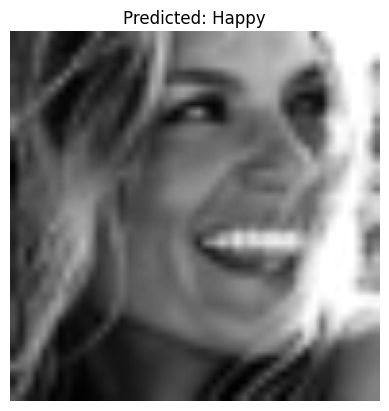

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Part 1: Emotion categories dictionary
num2class = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral"
}

# Part 2: Find indices of correct predictions
correct_indices = []
for i in range(len(y_pred_classes)):
    if y_test[i] == y_pred_classes[i]:
        correct_indices.append(i)

# Check if there are at least 5 correct predictions
if len(correct_indices) < 5:
    print(f"Only {len(correct_indices)} correct predictions found. Showing those.")
else:
    print(f"Showing 1 correct predictions.")

# Part 3: Display 2 random correct predictions with emotion category
random_indices = np.random.choice(correct_indices, 1, replace=False)

for idx in random_indices:
    # Load the image
    sample_image, _ = test_ds[idx]
    sample_image = sample_image.permute(1, 2, 0).numpy()  # Convert to HWC format
    gray_image = rgb2gray(sample_image)  # Convert to grayscale

    # Convert grayscale image to 8-bit (0-255)
    gray_image_8bit = np.uint8(gray_image * 255)

    # Plot the image with the emotion category
    plt.imshow(gray_image_8bit, cmap='gray')
    predicted_class = y_pred_classes[idx]
    emotion = num2class[predicted_class]
    plt.title(f"Predicted: {emotion}")
    plt.axis('off')  # Hide axes for clarity
    plt.show()


1. Class Distribution with Pie Chart

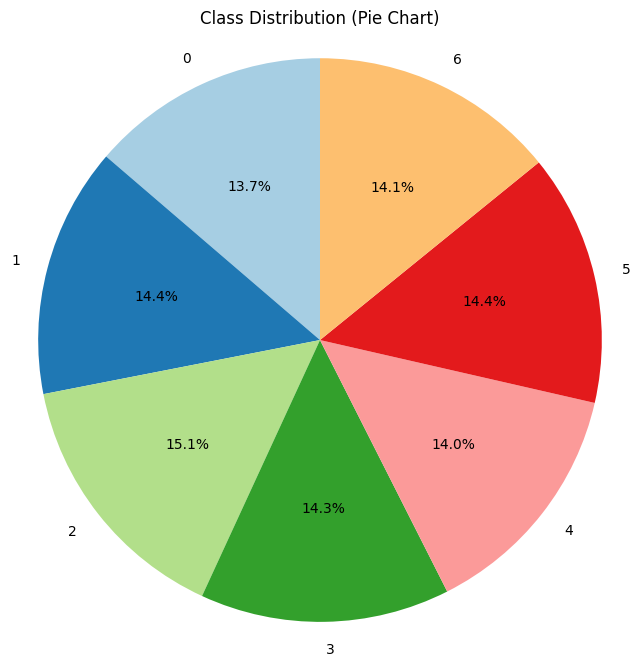

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'emotion_labels' is the list of emotion categories in the dataset
labels, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(8,8))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Class Distribution (Pie Chart)')
plt.axis('equal')
plt.show()


Learning Curves (Training vs. Validation Loss/Accuracy)

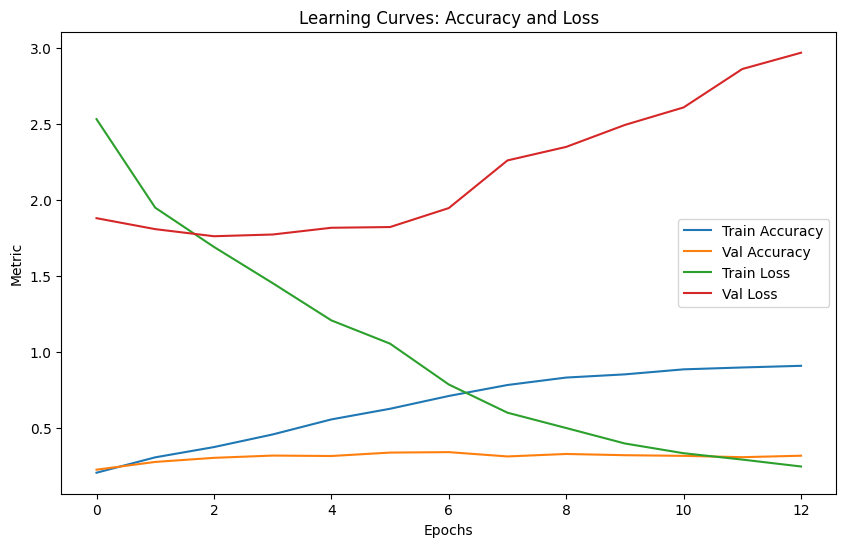

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Learning Curves: Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()
plt.show()


t-SNE (t-Distributed Stochastic Neighbor Embedding) for Dimensionality Reduction

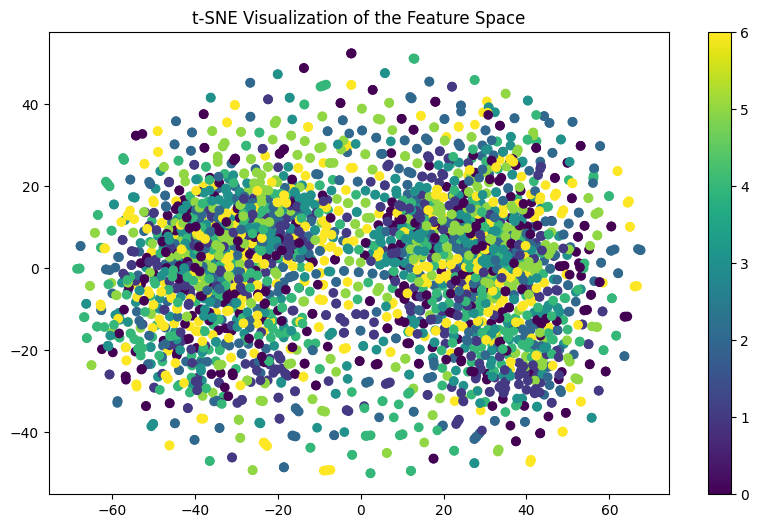

In [ ]:
from sklearn.manifold import TSNE

# Perform t-SNE on the scaled feature data
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X_train_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='viridis')
plt.colorbar(scatter)
plt.title('t-SNE Visualization of the Feature Space')
plt.show()


Heatmap for Correlation of Features